# Image segmentation
This notebook will cover some of the image segmentation method introduced in TDT4195.

In [2]:
#Imports
import numpy as np
from matplotlib import pyplot as plt
from ipywidgets import interact, interact_manual, FloatSlider
import ipywidgets as widgets

## Boundary based methods

### Basic edge detection
Edges in images are areas of discontinuties or rapid change in intensity. We can detect such discontinuties by taking the derivative of the images.

Images are discrete, so we need a discrete derivation. It can be shown that:
$$\frac{\partial f}{\partial x} = f(x+1,y) - f(x-1,y)$$
is a good approximation for images.

To apply the derivative we can convolve the image with a $[-1, 0, 1]$ kernel.

In [3]:
def convolve_image(image, kernel):
    h, w = image.shape[:2]
    kernel_size= kernel.shape[0]
    
    #Rotate 180 degrees in order to perform convolution and not correlation
    kernel = np.rot90(np.rot90(kernel))
    pad = (kernel_size - 1) // 2
    
    image = np.pad(image, pad_width = ((pad,pad), (pad,pad)), mode = "edge")
    
    output = np.zeros_like(image, dtype = np.float64)
    for y in range(h):
        for x in range(w):
            im_slice = image[y: y+kernel_size, x: x + kernel_size]
            
            value = np.sum(im_slice*kernel, axis = (0,1))
            output[y + pad, x + pad] = value
    
    #Normalize output
    output = output[pad:-pad, pad:-pad]
    return output



def derivate_image(image, kernel = np.array([[0,0,0], [1, 0, -1], [0,0,0]])):
    first_deriv = convolve_image(image, kernel)
    second_deriv = convolve_image(first_deriv, kernel)

    plt.figure(figsize=(10,11))
    plt.subplot(3,2,1)
    plt.title("Original")
    plt.imshow(image, cmap ="gray")
    
    plt.subplot(323)
    plt.title("First derivative")
    plt.imshow(first_deriv, cmap="gray")
    
    plt.subplot(325)
    plt.title("Second derivative")
    plt.imshow(second_deriv, cmap="gray")
    

    plt.subplot(322)
    plt.title("Original")
    plt.plot(image[0,:])
    
    plt.subplot(324)
    plt.title("First derivative")
    plt.plot(first_deriv[0,:])
    
    plt.subplot(326)
    plt.title("Second derivative")
    plt.plot(second_deriv[0,:])
    plt.show()
    
    

def derivation_wrapper(image_name):
    image = plt.imread(f"images/{image_name}.tif")
    derivate_image(image)
    
    
_ = interact_manual(derivation_wrapper, image_name = ["edge-ramp", "edge-roof", "edge-step"])

interactive(children=(Dropdown(description='image_name', options=('edge-ramp', 'edge-roof', 'edge-step'), valu…

This works really well as long as there is no noise in the images. When we add noise, the derivative will amplify that noise, leading to unusable results. It is surprising how little noise it takes before the result is unusable.

In [76]:
def derivate_image_with_noise(image_name, std):
    noise = np.random.normal(0, std, (128, 565))
    image = plt.imread(f"images/{image_name}.tif").astype(np.float32)
    image += noise
    derivate_image(image)

_ = interact_manual(derivate_image_with_noise, image_name = ["edge-ramp", "edge-roof", "edge-step"],\
                   std = widgets.FloatSlider(min = 0, max = 15, value=0))

interactive(children=(Dropdown(description='image_name', options=('edge-ramp', 'edge-roof', 'edge-step'), valu…

The solution is to apply image smoothening to eliminate some of the noise before derivating. The result is still not as good as if there was no noise, but it should be a bit more robust than earlier. 

In [77]:
def derivate_image_with_noise_and_smoothening(image_name, std, smoothen):
    noise = np.random.normal(0, std, (128, 565))
    image = plt.imread(f"images/{image_name}.tif").astype(np.float32)
    image += noise
    if smoothen:
        gaussian = np.array([[1,2,1], [2,4,2], [1,2,1]])/16
        image = convolve_image(image, gaussian)
    derivate_image(image)

_ = interact_manual(derivate_image_with_noise_and_smoothening, image_name = ["edge-ramp", "edge-roof", "edge-step"],\
                   std = widgets.FloatSlider(min = 0, max = 8, value=0),
                   smoothen = False)

interactive(children=(Dropdown(description='image_name', options=('edge-ramp', 'edge-roof', 'edge-step'), valu…

An alternative to convolving with a gaussian is to use the sobel-kernel. The soble-kernel is basically image-smoothening followed by the derivative combined into one kernel.

In [78]:
def derivate_image_with_noise_and_sobel(image_name, std, sobel):
    noise = np.random.normal(0, std, (128, 565))
    image = plt.imread(f"images/{image_name}.tif").astype(np.float32)
    image += noise
    if sobel:
        derivate_image(image, kernel = np.array([[1, 0, -1],[2,0,-2], [1,0,-1]]))
    else:
        derivate_image(image)

_ = interact_manual(derivate_image_with_noise_and_sobel, image_name = ["edge-ramp", "edge-roof", "edge-step"],\
                   std = widgets.FloatSlider(min = 0, max = 15, value=0),
                   sobel = False)

interactive(children=(Dropdown(description='image_name', options=('edge-ramp', 'edge-roof', 'edge-step'), valu…

### Image gradient

The gradient is a vector whose components are the partial derivatives of the function. In an image we can partial derivate with respect to x and with respect to y. We have so far only worked with x-derivatives, but we can easily calculate the y-derivative by rotating the derivation-kernel  $90 ^\circ$.

The image gradient will be an array of shape HxWx2. In this example I choose to visualize this by drawing an rgb image with the r-channel set to the x-derivative, g-channel set to the y-derivative and the b-channel set to 0. As you can see, this is not a very practical way to visualize the gradient and we will later explore better alternatives.

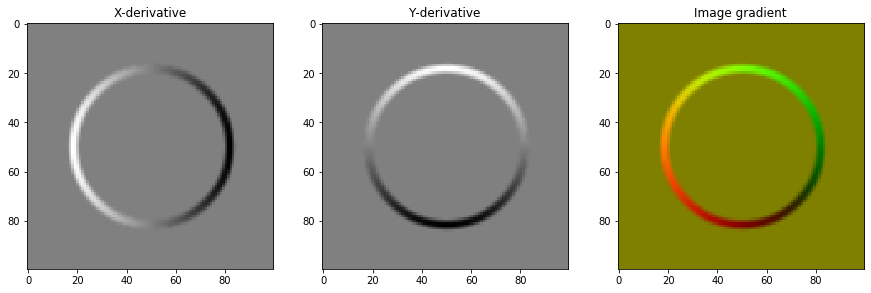

In [5]:
def make_circle_image(ramp_length):
    image = np.array([[255 if (x-50)**2 + (y-50)**2 < 900 else 0 for x in range(100)] for y in range(100)])
    for y in range(100):
        for x in range(100):
            if 900 <= (x-50)**2 + (y-50)**2 < 900 + ramp_length:
                image[y,x] = 255*(900 + ramp_length - ((x-50)**2 + (y-50)**2))/ramp_length
    return image

image = make_circle_image(200)
x_sobel = np.array([[1, 0, -1],[2,0,-2], [1,0,-1]])
y_sobel = np.array([[1,2,1], [0,0,0], [-1,-2,-1]])

x_derivative = convolve_image(image, x_sobel)
y_derivative = convolve_image(image, y_sobel)


gradient  = np.zeros((image.shape[0], image.shape[1], 3), dtype = np.uint8)
gradient[:,:,0] = (x_derivative - x_derivative.min())/(x_derivative.max() - x_derivative.min())*255
gradient[:,:,1] = (y_derivative - y_derivative.min())/(y_derivative.max() - y_derivative.min())*255

plt.figure(figsize = (15,5))
plt.subplot(131)
plt.title("X-derivative")
plt.imshow(x_derivative, cmap = "gray")

plt.subplot(132)
plt.title("Y-derivative")
plt.imshow(y_derivative, cmap = "gray")

plt.subplot(133)
plt.title("Image gradient")
plt.imshow(gradient)
plt.show()

As shold be know from basic mathematics-courses, two dimensional vectors can also be represented by a magnitude and direction.

In image-processing this is often times a much more practical way of representing the gradient than an x,y-vector.

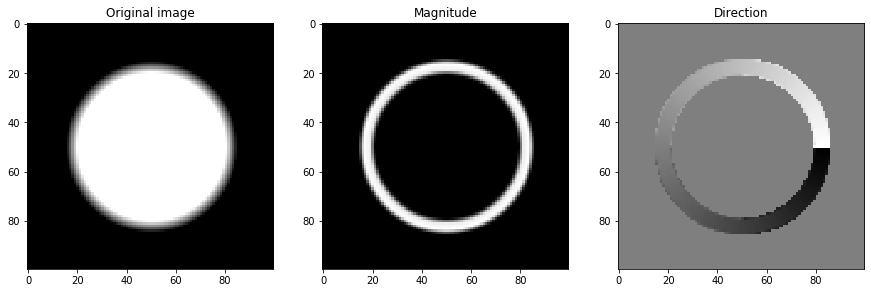

In [6]:
from skimage import data
image = make_circle_image(300)
def magnitude_direction_image(image):
    x_sobel = np.array([[1, 0, -1],[2,0,-2], [1,0,-1]])
    y_sobel = np.array([[1,2,1], [0,0,0], [-1,-2,-1]])

    x_derivative = convolve_image(image, x_sobel).astype(np.float32)
    y_derivative = convolve_image(image, y_sobel).astype(np.float32)

    magnitude = np.sqrt(x_derivative**2 + y_derivative**2).astype(np.float32)
    direction = np.arctan2(y_derivative, x_derivative).astype(np.float32)
    return magnitude, direction

magnitude, direction = magnitude_direction_image(image)

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.title("Original image")
plt.imshow(image, cmap = "gray")

plt.subplot(132)
plt.title("Magnitude")
plt.imshow(magnitude, cmap ="gray")

plt.subplot(133)
plt.title("Direction")
plt.imshow(direction, cmap = "gray")
plt.show()

### Non-maximum-supression
Picking up from where we left off with the gradient image we want to thin all edges so that each edge is only one pixel-width. The process of doing so is called non-maximum supression. 

The first step after calculating a magnitude and direction image is to quantizise the direction image into one of four directions.

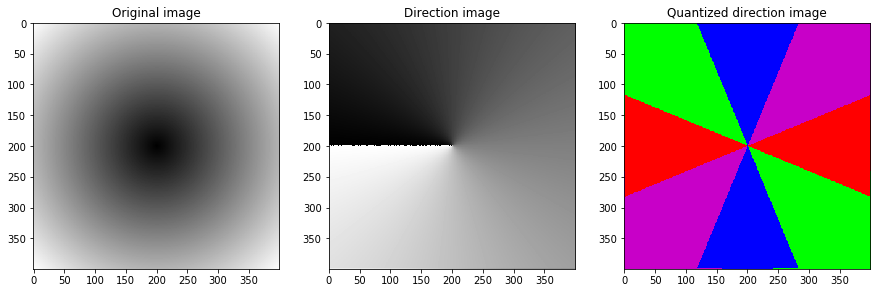

In [7]:
def quantize_direction(direction_image):
    return (8*(direction+9*np.pi/8)/(2*np.pi)).astype(int)%4

image = np.array([[np.sqrt((x-200)**2 + (y-200)**2) for x in range(400)] for y in range(400)])
magnitude, direction = magnitude_direction_image(image)


quant_dir = quantize_direction(direction)

colors = np.array([[255,0,0], [0,255,0], [0,0,255], [200,0,200]])
color_im = colors[quant_dir]

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.title("Original image")
plt.imshow(image, cmap = "gray")

plt.subplot(132)
plt.title("Direction image")
plt.imshow(direction, cmap = "gray")

plt.subplot(133)
plt.title("Quantized direction image")
plt.imshow(color_im)
plt.show()

We define an image with a wide edge for educational purposes. We calculate the magnitude, direction and quantized direction right away.

In [16]:
image = np.zeros((10,10))

image[:,2] = 200
image[:,3] = 225
image[:,4:6] = 245
image[:,6] = 225
image[:,7] = 200


magnitude, direction = magnitude_direction_image(image)
quant_dir = quantize_direction(direction)

Then we want to go over the image, and for each point look in the direction and negative direction of the gradient. We only keep the maximum values.

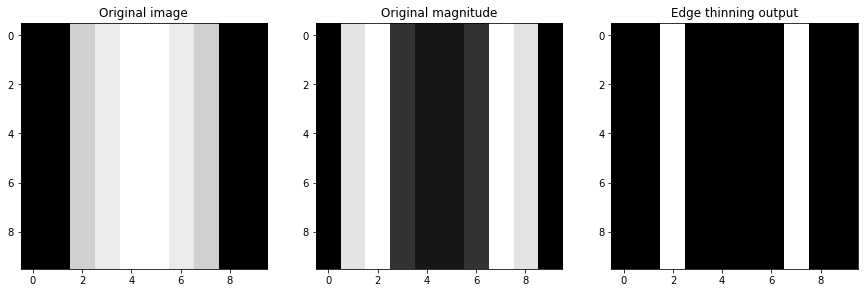

In [17]:
def edge_thinning(magnitude, direction):
    output = np.zeros_like(magnitude)
    discrete_dir = np.array([[0,1], [1,1], [1,0], [-1, 1]])
    h, w = magnitude.shape[:2]
    #Pad magnitude image, so that if we access outside we get zero
    magnitude = np.pad(magnitude, ((0,1), (0,1)), mode="constant")
    for y in range(h):
        for x in range(w):
            y1, x1 = np.array([y,x]) + discrete_dir[direction[y,x]]
            y2, x2 = np.array([y,x]) - discrete_dir[direction[y,x]]
            value = magnitude[y,x]
            if (magnitude[y1,x1] <= value and magnitude[y2,x2] < value):
                output[y,x] = value
            
    return output


edge = edge_thinning(magnitude, quant_dir)

plt.figure(figsize = (15,5))
plt.subplot(131)
plt.title("Original image")
plt.imshow(image, cmap ="gray")

plt.subplot(132)
plt.title("Original magnitude")
plt.imshow(magnitude, cmap ="gray")

plt.subplot(133)
plt.title("Edge thinning output")
plt.imshow(edge, cmap = "gray")
plt.show()


colors = np.array([[255,0,0], [0,255,0], [0,0,255], [200,0,200]])
color_im = colors[quant_dir]

### Edge linking
The output of the edge thinning step normally gives edges of variable strength. Some edges were weak, others strong. There may also be quite alot of noise which we want to remove. We want to connect the true edges to continous curves or lines, ignoring the noise. The solution to this is double threshold hysterisis. We first use one threshold to capture all true edge-points. Then we use a lower threshold to connect the true edge-points by weaker thresholds. The first thresholding should filter out all noise, the second threshold should only consider the low activations that are connected to true edges.

This is illustrated here with an image with variable strength edge and some noise.

In [42]:
edge = np.zeros((10,10))
#Add edge
edge[3, :] = 100
edge[3,::3] = 225
edge[:,5] = 100
edge[::4,5] = 225

#Add noise
edge[5,3] = 120
edge[7,2] = 123
edge[4,8] = 120

quant_dir = np.zeros((10,10), dtype = np.uint8)
quant_dir[3,:] = 2
quant_dir[:,5] = 0


def edge_linking(edge, direction, thresh1, thresh2):
    discrete_dir = np.array([[1,0], [-1,1], [0,1], [1, 1]])
    true_edges = edge > thresh1
    output = true_edges.copy()
    h,w = edge.shape
    #Pad edge image so that we get zero if we access outside
    edge = np.pad(edge, ((0,1), (0,1)), mode = "constant")
    for y in range(h):
        for x in range(w):
            if(true_edges[y,x]):
                #Look first in positive direction
                y1, x1 = np.array([y,x]) + discrete_dir[direction[y,x]]
                while(edge[y1,x1] > thresh2):
                    output[y1,x1] = True
                    y1, x1 = np.array([y1, x1]) + discrete_dir[direction[y1,x1]]
                #Then look in negative direction
                y1, x1 = np.array([y,x]) - discrete_dir[direction[y,x]]
                while(edge[y1,x1] > thresh2):
                    output[y1,x1] = True
                    y1, x1 = np.array([y1, x1]) - discrete_dir[direction[y1,x1]]
    return output


def display_edge_link(thresh1, thresh2):
    edge_linked = edge_linking(edge, quant_dir, thresh1, thresh2)

    plt.figure(figsize = (15,5))

    plt.subplot(121)
    plt.title("NMS output")
    plt.imshow(edge, cmap = "gray")
    plt.subplot(122)
    plt.title("Edge linking output")
    plt.imshow(edge_linked, cmap ="gray")

    plt.show()  
    
_ = interact_manual(display_edge_link, thresh1 = widgets.IntSlider(min = 0, max = 450),
                           thresh2 = widgets.IntSlider(min = 0, max = 300))

interactive(children=(IntSlider(value=0, description='thresh1', max=450), IntSlider(value=0, description='thre…

### Canny-edge detector
If we combine all the steps we have done so far, we get an edge detection method called Canny-edge detector. The Canny edge detector is derived to be the optimal edge detector to find steep edges in the presence of white noise. 

We do not need to implement the algorithms ourselvs each time we want to apply Canny-edge-detection. OpenCV has a good implementation which we can use. This section will demonstrate how to apply Open CV's implementation. The documentation can be found [here](https://docs.opencv.org/2.4/modules/imgproc/doc/feature_detection.html) and a short tutorial can be found [here](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_canny/py_canny.html).

In [ ]:
import cv2
def display_canny(image_name, threshold1, threshold2):
    images = {"retina" : data.retina(),
              "gloshaugen" : plt.imread("images/gloshaugen.jpg")}
    image = images[image_name]
    #convert image to gray-scale
    image = np.dot(image, [0.2989, 0.5870, 0.1140])
    image = image.astype(np.uint8)

    #Find edges
    edges = cv2.Canny(image, threshold1, threshold2)

    #Plot result
    plt.figure(figsize=(10,20))
    plt.subplot(1,2,1)
    plt.title("Original image")
    plt.imshow(image, cmap = "gray")
    plt.subplot(1,2,2)
    plt.title("Canny-edge output")
    plt.imshow(edges, cmap = "gray")
    plt.show()
    
    
    
_ = interact_manual(display_canny, image_name = ["retina", "gloshaugen"],
                   threshold1 = widgets.IntSlider(min = 1, max = 300),\
                   threshold2 = widgets.IntSlider(min = 1, max = 300))

### Hough transform

Hough transform is a feature extracting method for extracting simple features such as lines, circles or polygons. The algorithm transforms each point in an image into hough-space. A point in image space is a sinusoidal curve in the hough-space. Similarly, a point in hough-space is a line in the image-space. Thus, since a line consists of many points, the sinusoidals corresponding to each point in a line will intersect in the point in hough-space that correspond to that line.

This notebook will demonstrate an implementation of the hough-transform for line-detection. This is for educational purposes only, normally you would not need to implement the hough-transform yourself. Open CV, for instance, has available implementations that you can use. A guide for hough-transform with Open CV can be found [here](https://livecodestream.dev/post/2020-05-26-hough-transformation/).

#### Generating the voting table
Hough-space is a 2d-space, and thus the voting table is a two-dimensional array. For this implementation it was chosen to let $\theta$ run through the x-axis and $\rho$ through the y-axis.

The x-axis is divided into a fixed number of steps, where index 0 represents $- \frac{\pi}{2}$, and the max index represents $\frac{\pi}{2}$.

The y-axis is also normaly divided into a fixed number of steps, but for simplicity this implementation chose to let the values range from $x[0] = \rho_{min}$ to $x[len(x)-1] = \rho_{max}$

To transform an x, y pair into hough-space we run through all possible $\theta$ values between $- \frac{\pi}{2}$ and $\frac{\pi}{2}$ and calculate the corresponding $\rho$.

$$\rho = x \cos{\theta} + y \sin{\theta}$$

In [92]:
def generate_hough_table(im: np.ndarray, steps = 256):
    rho_max = np.sqrt(im.shape[0]**2 + im.shape[1]**2)
    rho_min = -im.shape[0]
    #Initialize voting table
    hough = np.zeros((int(rho_max-rho_min), steps))
    for y in range(im.shape[0]):
        for x in range(im.shape[1]):
            if im[y,x]:
                #Vectorization of theta, rho calculation with numpy
                theta = np.linspace(-np.pi/2,np.pi/2,steps)
                rho = x*np.cos(theta) + y*np.sin(theta)
                #For each possible theta increment corresponding rho
                for r,t in zip(rho, range(steps)):
                    hough[int(r - rho_min), t] += 1
    return hough

#### Recovering lines from voting table
To recover the lines from the voting table we must find the cells with high number of votes in the hough table. This implementation has chosen to simply threshold the image. A better method would look for local maximums and suppress neightboring maximums.

Once we have found the x,y values in the hough table that correspond to lines in image space, we can recover the rho and theta. When we know rho and theta, we can draw lines by solving the transformation equation for y:
$$ y = \frac{\rho - x \cos{\theta}}{\sin{\theta}}$$

In [214]:
def hough_table_to_rho_theta(x, y, im_shape, steps=256):
    theta = x/steps * np.pi - np.pi/2
    rho = y - im_shape[0]
    return rho, theta


def find_lines(hough_table, im_shape, threshold, steps = 256):
    line_image = np.zeros(im_shape)
    for h_y in range(hough_table.shape[0]):
        for h_x in range(hough_table.shape[1]):
            # Chech if number of votes are more than the threshold
            if hough_table[h_y,h_x] >= threshold:
                #Recover rho and theta from x, y in hough_table
                rho, theta = hough_table_to_rho_theta(h_x, h_y, im_shape, steps)
                if np.sin(theta) == 0:
                    continue
                line_x = np.arange(im_shape[1])
                line_y = (rho - line_x*np.cos(theta))/np.sin(theta)
                for ly, lx in zip(line_y, line_x):
                    if(ly < im_shape[0] and ly >= 0):
                        line_image[int(ly), lx] += 1
    return line_image

#### Bringing it all together
Normally we run hough-transform over edge images, for instance the output of a canny-edge detector. For educational purposes, this notebook demonstrates hough transform on discontinous lines.

The first line here is represented by two pixels. This is enough for the hough transform to detect a line.

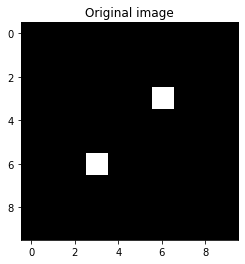

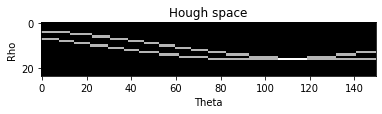

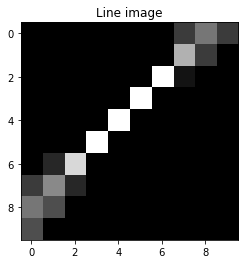

In [230]:
im = np.zeros((10,10), dtype = bool)
im[3,6] = True
im[6,3] = True
plt.figure()
plt.imshow(im, cmap = "gray")
plt.title("Original image")
plt.show()

hough_table = generate_hough_table(im, steps = 150)

plt.figure()
# Gamma transform hough-image for better visibility
plt.imshow((hough_table/np.max(hough_table))**0.5, cmap = "gray")
plt.title("Hough space")
plt.xlabel("Theta")
plt.ylabel("Rho")
plt.show()


line_image = find_lines(hough_table, im.shape, threshold = 2, steps = 150)


plt.figure()
plt.imshow(line_image, cmap = "gray")
plt.title("Line image")
plt.show()



Naturally it is easier to detect stronger lines represented by more pixels. In the interaction below you can try to add noise to the line-image. Notice that when you increase the number of line-pixels and the threshold value, the method is more robust to noise.

In [234]:
import random
def generate_image(num_pixels):
    im = np.zeros((50, 50))
    for i in range(num_pixels):
        im[int(i*(50/num_pixels)),int(i*(50/num_pixels))] = 1
    return im.astype(bool)




def plot_wrapper_noise(voting_threshold, num_pixels, noise_std):
    im = generate_image(num_pixels)
    noise = np.random.normal(0, noise_std, (50,50)).astype(np.uint8).astype(bool)
    im += noise
    plt.figure()
    plt.imshow(im, cmap = "gray")
    plt.title("Original image")
    plt.show()

    hough_table = generate_hough_table(im, steps = 150)

    plt.figure()
    # Gamma transform hough-image for better visibility
    plt.imshow((hough_table/np.max(hough_table))**0.5, cmap = "gray")
    plt.title("Hough space")
    plt.xlabel("Theta")
    plt.ylabel("Rho")
    plt.show()


    line_image = find_lines(hough_table, im.shape, threshold = voting_threshold, steps = 150)


    plt.figure()
    plt.imshow(line_image, cmap = "gray")
    plt.title("Line image")
    plt.show()

_ = interact_manual(plot_wrapper_noise, voting_threshold = widgets.IntSlider(min = 1, max = 50),
                   num_pixels = widgets.IntSlider(min = 1, max = 50),
                   noise_std = widgets.FloatSlider(min = 0., max = 1.0))

interactive(children=(IntSlider(value=1, description='voting_threshold', max=50, min=1), IntSlider(value=1, de…

### Exercise - Hough transform for lines
Apply canny edge detector on the following image. Then use hough transform to generate lines, and impose them on the original image. If you understood the algorithm from the python implementation above, feel free to try out [Open CV's implementation](https://docs.opencv.org/2.4/modules/imgproc/doc/feature_detection.html#houghlines) instead.

In [ ]:
image = plt.imread("images/airport.tif")
plt.imshow(image, cmap = "gray")
plt.show()

#### Example solution

##### Generating edge image
We start by generating an edge-image from the original image with Open CV's Canny edge detector. This time we blur the image before applying the canny edge detector. This will leave us with only the most dominant edges.

In [ ]:
image = plt.imread("images/airport.tif")

blurred_image = cv2.medianBlur(image, 3)
edges = cv2.Canny(blurred_image, threshold1 = 200, threshold2 = 450)
plt.figure(figsize=(10,20))
plt.subplot(1,2,1)
plt.imshow(image, cmap = "gray")
plt.subplot(1,2,2)
plt.imshow(edges, cmap = "gray")
plt.show()

##### Drawing hough lines with open CV

In [ ]:
def impose_lines_on_gray_image(gray_image, line_mask):
    color_image = np.array([image for i in range(3)], dtype = np.uint8)
    color_image = np.ascontiguousarray(color_image.transpose(1,2,0))

    color_image[line_mask] = [255,0,0]
    return color_image

In [ ]:
#Open CV's implementation returns a list of rho's and theta's
steps = 180
threshold = 80
lines = cv2.HoughLines(edges, 1, np.pi/steps, threshold)

# Draw lines on the image
line_image = np.zeros_like(image, dtype = bool)
for line in lines:
    rho, theta = line[0]
    for line_x in range(image.shape[1]):
        if(np.sin(theta) != 0):
            line_y = (rho - line_x*np.cos(theta))/np.sin(theta)
            if(line_y < image.shape[0] and line_y > 0):
                line_image[int(line_y), line_x] = True

color_image = impose_lines_on_gray_image(image, line_image)
plt.imshow(color_image)
plt.show()

##### Drawing hough lines with python implementation

In [ ]:
steps = 180
threshold = 100
hough_table = generate_hough_table(edges, steps)

plt.figure()
# Gamma transform hough-image for better visibility
plt.imshow((hough_table/np.max(hough_table))**0.5, cmap = "gray")
plt.title("Hough space")
plt.xlabel("Theta")
plt.ylabel("Rho")
plt.show()

line_image = find_lines(hough_table, image.shape, threshold, steps).astype(bool)
color_image = impose_lines_on_gray_image(image, line_image)

plt.figure()
plt.imshow(color_image, cmap = "gray")
plt.title("Original image with drawn lines")
plt.show()

### Exercise - Hough transform for circles
With what you have learnt so far, try to detect circles with [Hough transform for circles](https://docs.opencv.org/2.4/modules/imgproc/doc/feature_detection.html#houghcircles) on the following image.

In [ ]:
image = plt.imread("images/wood-dowels.tif")
plt.imshow(image, cmap = "gray")
plt.show()

#### Example solution

A difficult part of this example is that in contrast to Hough Lines, the cv2.HoughCircles does not need you to apply edge detection first. This is not imediately clear from the documentation.

In [ ]:
image = plt.imread("images/wood-dowels.tif")
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(image, cmap = "gray")

#First blur the image to reduce noise
img_blur = cv2.medianBlur(image, 5)

#Find all circles
circles = cv2.HoughCircles(img_blur, cv2.HOUGH_GRADIENT, 1,\
                           20, param1=200, param2=15, minRadius=15, maxRadius=30)

#Create image of shape h,w,3 instead of h,w
color_image = np.array([image for i in range(3)], dtype = np.uint8)
color_image = np.ascontiguousarray(color_image.transpose(1,2,0))

#Draw circles
if circles is not None:
    circles = np.array(circles, dtype = np.uint64)
    for i in circles[0, :]:
        # Draw outer circle
        cv2.circle(color_image, (i[0], i[1]), i[2], (255, 0, 0), 2)
        # Draw inner circle
        cv2.circle(color_image, (i[0], i[1]), 2, (0, 0, 255), 3)
plt.subplot(1,2,2)
plt.imshow(color_image, cmap = "gray")
plt.show()

## Region based methods

### Thresholding
A very simple segmentation method is to threshold the image. This can be done with greyscale images by thresholding the intensity value. In color images one can threshold individual color channels or threshold on a comparison of the color channels.

#### Intuition
This code demonstrates how we can get quick, and simple results from thresholding. Later topics will discuss how to find optimal threshold values based on statistics.

In [ ]:
image_path = "images/strawberry.jpg"
image = plt.imread(image_path)


result = np.zeros_like(image)
for y in range(image.shape[0]):
    for x in range(image.shape[1]):
        #Set the pixel to black if blue is the dominant color
        result[y,x,:] = image[y,x,:] if image[y,x,0]**2 + image[y,x,1]**2 > image[y,x,2]**2 else [0,0,0]
plt.imshow(result)
plt.show()

result = np.zeros_like(image)
for y in range(image.shape[0]):
    for x in range(image.shape[1]):
        result[y,x,:] = image[y,x,:] if image[y,x,0]**2 + image[y,x,1]**2 < image[y,x,2]**2 else [0,0,0]
plt.imshow(result)
plt.show()

#### Supervised thresholding
With supervised thresholding you have full controll over the threshold value. This allows you to make fine adjustments in order to achieve the best desired result. Since you are picking the threshold values manually, this is naturally a much slower process than the automatic threhsolding algorithms that will be displayed later. Sometimes supervised thresholding is, however, necessary. You will find that with supervised thresholding it is quite easy to segment the text in the image "text-spotshade", the unsupervised methods, on the other hand, fail to do so. With the following imags, try to find threshold values that mask out the objects of interest from the image.

In [ ]:
def supervised_threshold(image, thresh):
    image_mask = image > thresh
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.imshow(image, cmap = "gray")
    plt.subplot(1,3,2)
    plt.imshow(image_mask, cmap = "gray")
    plt.subplot(1,3,3)
    hist, bins, _ = plt.hist(image.reshape(-1), range(257))
    plt.bar(thresh, np.max(hist) + 1000, color = "red")
    plt.bar(thresh+1, np.max(hist) + 1000, color = "red")
    plt.bar(thresh-1, np.max(hist) + 1000, color = "red")
    plt.show()
    
    
def supervised_wrapper(image_name, thresh):
    image = plt.imread(f"images/{image_name}.tif")
    supervised_threshold(image, thresh)
_ = interact_manual(supervised_wrapper,image_name = ["wood-dowels", "airport", "calculator", "fingerprint", "text-spotshade"],\
                    thresh = widgets.IntSlider(min = 0, max = 255, step = 1, value = 100))

The following cell will show a sligthly more difficult example. From playing around with different thresholds you will experience that not global threhsold successfully extracts the text. If we are not able to extract the text with supervised threshold selection, then none of the other global threshold algorithms will work either. Usage of more advanced methods will be demonstrated at the end of this section.

In [ ]:
from skimage import data

_ = interact_manual(supervised_threshold,image = widgets.fixed(data.page()),\
                    thresh = widgets.IntSlider(min = 0, max = 255, step = 1, value = 100))

#### Heuristic thresholding
Heuristic thresholding works by iteratively choosing a new threshold value until there is no more change.
1. Select an initial estimate for threshold T
2. Segment the image using T
    * G1 is all pixels with intensities > T
    * G2 is all pixels with intensities <= T
3. Compute averages m1 and m2 for the pixels in G1 and G2
4. Let T = (m1+m2)/2
5. Repeat steps 1-4 until no more change

In [ ]:
def heuristic_threshold(image, initial_guess):
    hist, bins = np.histogram(image.reshape(-1), range(0,257))
    cumulative_hist = np.cumsum(hist)
    prev_guess = -1
    while(prev_guess != initial_guess):
        m1 = 0
        for i in range(initial_guess):
            m1 += i*hist[i]
        m1 /= cumulative_hist[initial_guess]
        
        
        m2 = 0
        for i in range(initial_guess, 256):
            m2 += i*hist[i]
        m2 /= cumulative_hist[-1] - cumulative_hist[initial_guess]
        
        prev_guess = initial_guess
        initial_guess = int((m1 + m2)/2)
    return initial_guess
    


def basic_threshold_image(image_name):
    image = plt.imread(f"images/{image_name}.tif")
    threshold = heuristic_threshold(image,100)
    print(f"Final threshold: {threshold}")
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(image, cmap = "gray")
    plt.subplot(1,2,2)
    plt.imshow(image>=threshold, cmap = "gray")
    plt.show()
    
_ = interact_manual(basic_threshold_image, image_name = ["wood-dowels", "airport", "calculator", "fingerprint", "text-spotshade"])

#### Otsu threshold
Normally we don't choose the threshold values ourselves. Instead we use algorithms to find optimal threshold levels. One such algorithm is otsu threshold.

In [ ]:
def otsu_thresholding(im: np.ndarray) -> int:
    # Compute normalized histogram
    hist, bins = np.histogram(im.reshape(-1), range(0,257))
    normal_hist = hist/np.sum(hist)
    #Compute cumulative sum
    assert abs(sum(normal_hist) - 1.0)<0.001
    #Then we calculate the cumulative histogram
    cumulative_hist = np.cumsum(normal_hist)

    
    #Compute cumulative means
    cum_mean = np.zeros(256)
    total = 0
    for i in range(256):
        total += (i+1)*normal_hist[i]
        cum_mean[i] = total
    #Compute global mean
    glob_mean = cum_mean[-1]
    
    #Compute between-class variance
    variance = np.zeros(256)
    for k in range(256):
        if(cumulative_hist[k]>0 and cumulative_hist[k]<1):
            variance[k] = (glob_mean*cumulative_hist[k] - cum_mean[k])**2
            variance[k] /= (cumulative_hist[k]*(1-cumulative_hist[k]))
    
    #Compute otsu threshold
    threshold = 0
    equalThresholds = [0] #If multiple thresholds have the same variance, calculate mean
    for i in range(1, 256):
        if variance[i]>variance[threshold]:
            threshold = i
            equalThresholds = [i]
        elif variance[i] == variance[threshold]:
            equalThresholds.append(i)
    threshold = np.mean(equalThresholds)
    return threshold


def otsu_threshold_image(image_name):
    image = plt.imread(f"images/{image_name}.tif")
    threshold = otsu_thresholding(image)
    print(f"Final threshold: {threshold}")
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(image, cmap = "gray")
    plt.subplot(1,2,2)
    plt.imshow(image>=threshold, cmap = "gray")
    plt.show()
    
_ = interact_manual(otsu_threshold_image, image_name  = ["wood-dowels", "airport", "calculator", "fingerprint", "text-spotshade"])




#### Advanced methods
This subsection demonstrates more advanced local thresholding methods. The implementation details of the methods is not within the scope of this course, but it is important to note the existence of such methods. The key-difference is that instead of calculating a global threshold used for the whole image, these methods calculate a threshold mask with unique threshold values for each pixel. The threshold values are determined by looking at a local neighborhood around each pixel instead of looking at the whole image.


In [ ]:
from skimage import filters
#text_image = data.page()

def local_threshold(text_image, method="local"):
    text_image = images[text_image]
    if method == "local":
        text_threshold = filters.threshold_local(text_image, 35, offset = 10)
    elif method == "Niblack":
        text_threshold = filters.threshold_niblack(text_image, 45, k = 0.8)
    elif method == "Sauvola":
        text_threshold = filters.threshold_sauvola(text_image, 25)
    else:
        raise(ValueError("Method not implemented"))
    plt.figure(figsize = (18,6))
    
    plt.subplot(1,3,1)
    plt.title("Original image")
    plt.imshow(text_image, cmap ="gray")
    
    plt.subplot(1,3,2)
    plt.title("Threshold mask")
    plt.imshow(text_threshold, cmap = "gray")

    plt.subplot(1,3,3)
    plt.title("Result")
    plt.imshow(text_image > text_threshold, cmap = "gray")
    plt.show()
    
images = {"hand_written" : plt.imread("images/text-spotshade.tif"),
          "book" : data.page()}



_ = interact_manual(local_threshold, text_image = images.keys(), method = ["local", "Sauvola", "Niblack"])



### Region growing
Region growing is a simple segmentation method similar to the [flood fill algorithm](https://en.wikipedia.org/wiki/Flood_fill). We choose a seed and grow the area as long as neighboring pixels are similar to the seed. Skimage has a good implementation which we can use. Documentation can be found [here](https://scikit-image.org/docs/dev/api/skimage.segmentation.html#flood).

In [63]:
def draw_image_with_seeds(image, seeds):
    color_image = np.array([image for i in range(3)], dtype = np.uint8)
    color_image = np.ascontiguousarray(color_image.transpose(1,2,0))
    
    for y, x in seeds:
        color_image[y-2:y+2,x-2:x+2] = [255,0,0]
    plt.figure(figsize=(15,10))
    plt.title("Image with seeds")
    plt.imshow(color_image)
    plt.show()

Python implementation of the region growing algorithm. Your seeds are visualized by the function. Try to choose seeds and thresholds that best segment the image.

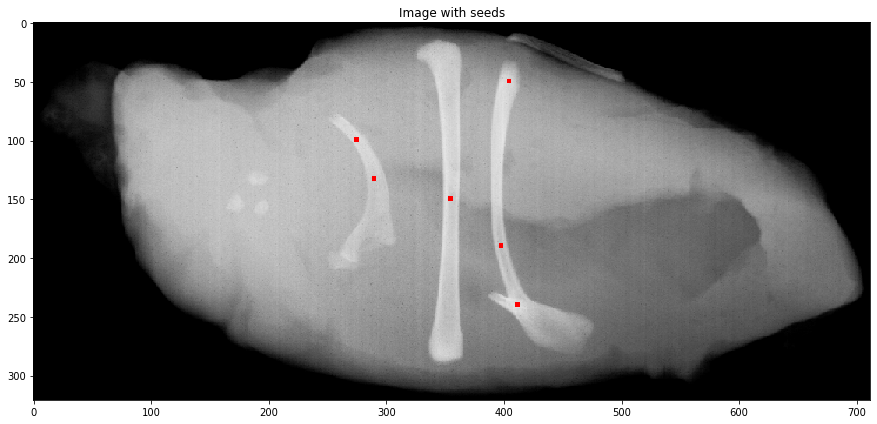

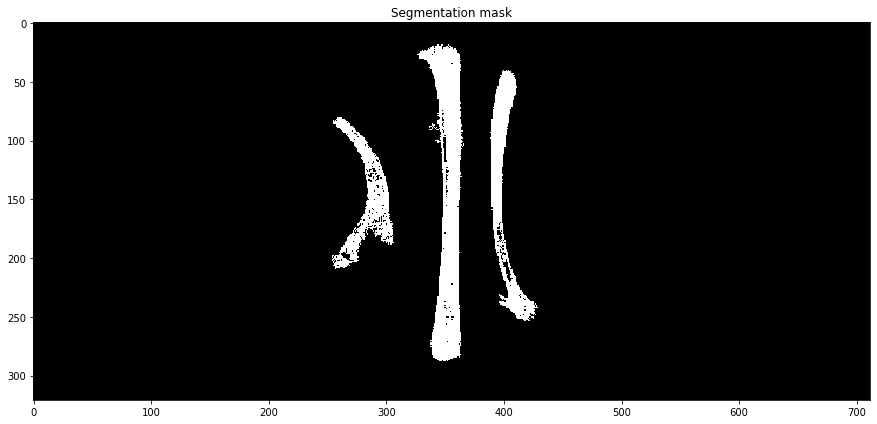

In [72]:
def region_growing(image, seeds, tolerances):
    result = np.zeros_like(image).astype(bool)
    for seed, tol in zip(seeds, tolerances):
        stack = [seed]
        initial_value = image[seed]
        while len(stack)>0:
            r, c = stack.pop()
            result[r, c] = True
            for i in range(-1,2):
                for j in range(-1,2):
                    if r+i >= 0 and r+i < image.shape[0] and c+j >=0 and c+j<image.shape[1]:
                        difference = image[r+i, c+j] - initial_value\
                                        if image[r+i, c+j] > initial_value\
                                        else initial_value - image[r+i, c+j]
                        if not result[r+i,c+j] and difference<tol:
                            if (r+i,c+j) not in stack:
                                stack.append((r+i, c+j))
    return result

def region_grow(seeds, tolerances):
    image = plt.imread("images/chickenXray.tif")
    draw_image_with_seeds(image, seeds)

    result = region_growing(image, seeds, tolerances)
    plt.figure(figsize=(15,10))
    plt.title("Segmentation mask")
    plt.imshow(result, cmap = "gray")
    plt.show()
    
seeds = [(150,355), (240,412), (50,405),(133, 290), (190, 398), (100, 275)]
tolerances = [21, 21, 21, 8, 6, 8]
region_grow(seeds, tolerances)

Demonstration of skimage implementation of region growing algorithm.

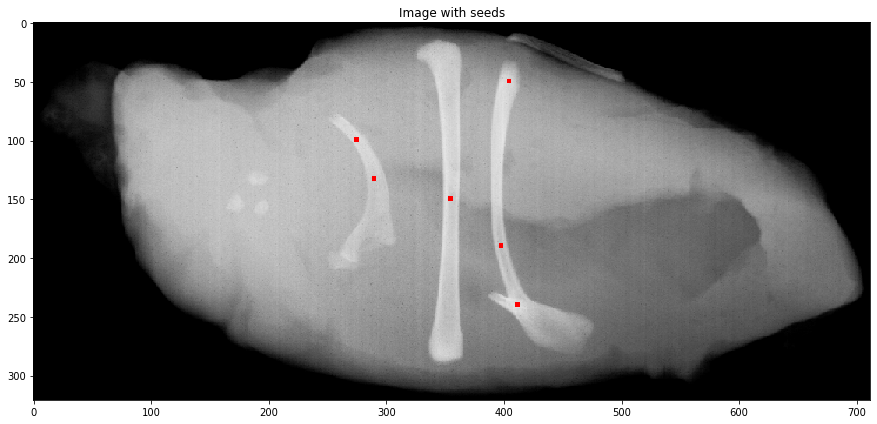

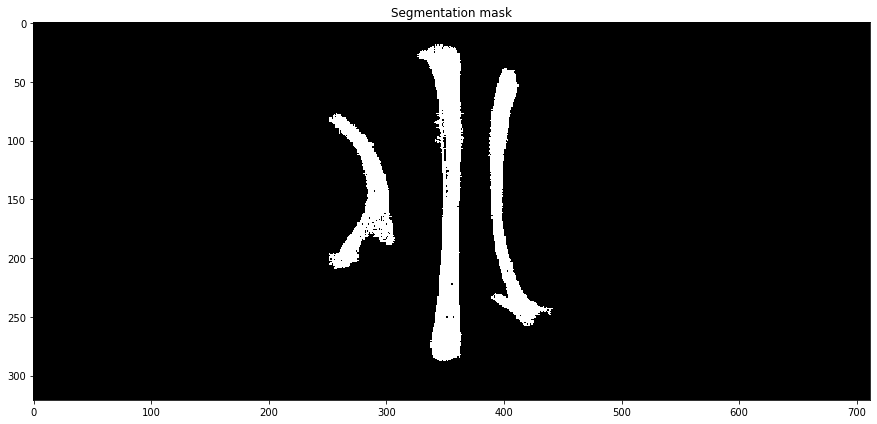

In [71]:
from skimage.segmentation import flood
def region_grow(seeds, tolerances):
    image = plt.imread("images/chickenXray.tif")

    draw_image_with_seeds(image, seeds)
    
    #Four-connectedness instead of eight-connectedness
    selem = np.array([[0,1,0],[1,1,1], [0,1,0]])
    #Result-mask
    mask = np.zeros(image.shape, dtype = bool)
    #skimage's implementation can only take one seed at a time
    for seed, tol in zip(seeds, tolerances):
        mask |= flood(image, seed, selem = selem, tolerance=tol)
        
    plt.figure(figsize=(15,10))
    plt.title("Segmentation mask")
    plt.imshow(mask, cmap = "gray")
    plt.show()
    
seeds = [(150,355), (240,412), (50,405),(133, 290), (190, 398), (100, 275)]
tolerances = [21, 40, 21, 10, 10, 21]
region_grow(seeds, tolerances)